In [2]:
import os

os.chdir('/home/enis/projects/nna/src/nna/exp/megan/run-1/')


In [3]:
# import run
# import nna
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchaudio
torchaudio.set_audio_backend("sox_io")

import numpy as np

/scratch/enis/conda/envs/soundenv3/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [4]:
import runconfigs
import wandb
from ignite.metrics import Accuracy, Loss
from ignite.contrib.metrics import ROC_AUC

In [5]:
# from nna.exp import augmentations,
from nna.exp import modelArchs,runutils

In [6]:
# wandb.init(config=runconfigs.default_config, project=runconfigs.PROJECT_NAME)
# config = wandb.config
config = runconfigs.default_config
# wandb.config.update(args) # adds all of the arguments as config variables

params = {
    'batch_size': config['batch_size'],
    'shuffle': True,
    'num_workers': 0
}


In [7]:
device = torch.device(
    f"cuda:{config['device']}" if torch.cuda.is_available() else "cpu")


In [8]:
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split

# labelsbyhumanpath = Path('/scratch/enis/data/nna/labeling/results/')
# sourcePath = Path("/scratch/enis/data/nna/labeling/splits/")


In [9]:
CATEGORY_COUNT = 2


In [10]:
from collections import Counter


In [11]:
 # RAW DATA
def load_raw_data(sample_count,CATEGORY_COUNT):
    sample_count = 1200
    X = np.empty((sample_count,480000),dtype=np.float32)
    y_true = np.random.randint(0,CATEGORY_COUNT,(sample_count))
    for i,y in enumerate(y_true):
        X[i,:] = y
    X = np.interp(X, (X.min(), X.max()), (-32768 , 32767))
    n_values = np.max(y_true) + 1
    y_true = np.eye(n_values)[y_true]
    X_train, X_test, y_train, y_test = train_test_split(
                    X, y_true, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(
                    X_train, y_train, test_size=0.25,random_state=42)
    return X_train,X_test,X_val,y_train,y_test,y_val

def mock_raw_data(sample_count,CATEGORY_COUNT):
#     sample_count = 30
    X = np.empty((sample_count*CATEGORY_COUNT,480000),dtype=np.float32)
    # y_true = np.random.randint(0,CATEGORY_COUNT,(sample_count))
    y_true=[]
    for i in range(CATEGORY_COUNT):
        y_true.extend([i]*sample_count)
    print(len(y_true))
    for i,y in enumerate(y_true):
        X[i,:] = y
    X = np.interp(X, (X.min(), X.max()), (0 , 3400))
#     X = np.interp(X, (X.min(), X.max()), (-32768 , 32767))
    n_values = np.max(y_true) + 1
    y_true = np.eye(n_values)[y_true]
    X_train, X_test, y_train, y_test = train_test_split(
                    X, y_true, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(
                    X_train, y_train, test_size=0.25,random_state=42)
#     print(y_train)
    return X_train,X_test,X_val,y_train,y_test,y_val
    


In [12]:
## Load real data rather than mock 
    # MVP1: delete parts longer than 10 seconds
import run
audio_dataset,_ = run.prepare_dataset()

output_file_path = '/scratch/enis/data/nna/labeling/megan/AudioSamplesPerSite/files_as_np_filtered_v3_int16.pkl'
audio_dataset.load_audio_files(output_file_path)
audio_dataset.pick_channel_by_clipping()


/scratch/enis/data/nna/labeling/megan/AudioSamplesPerSite/meganLabeledFiles_wlenV1.txt
/scratch/enis/data/nna/labeling/megan/AudioSamplesPerSite
4 files are missing corresponding to excell entries
'-> 5 number of samples are DELETED due to ignore_files and missing_audio_files'
-> 415 samples DELETED because they are not in the excell

-> 0 samples DELETED because they do not have the taxo info coming from excell

-> classes that do not have enough data:
[REMOVED!]
['other-mammal'] 0.0
['other-silence'] 20.0
['unknown-sound'] 2.0
['seabirds'] 1.0
['canids'] 1.0
['other-flare'] 11.0
['other-rain'] 20.0

-> classes that have enough data:
['other-biophony'] 56.0
['other-insect'] 140.0
['other-bird'] 661.0
['songbirds'] 392.0
['duck-goose-swan'] 183.0
['grouse-ptarmigan'] 59.0
['other-anthrophony'] 66.0
['other-aircraft'] 107.0
['loons'] 29.0
['other-car'] 37.0
('-> 102 number of samples are deleted because their taxonomy category does '
 'not have enough data.')
-> classes that do not have

In [13]:
# sound_ins[1].taxo_code
# classA = 1.1.7 #'duck-goose-swan']
# classB = 0.2.0 # other-aircraft
sampleTest= []
y=[]
expected_len=10
for sound_ins in audio_dataset.values():
    if sound_ins.taxo_code in ['1.1.10','1.1.7']:
        y.append(sound_ins.taxo_code)
        if sound_ins.length<10:
            tile_reps=(expected_len/(sound_ins.length)+1)
            repeated_data = np.tile(sound_ins.data,int(tile_reps))
            repeated_data = repeated_data[:expected_len*sound_ins.sr]
            sampleTest.append(repeated_data)
        else:
            sampleTest.append(sound_ins.data[:expected_len*sound_ins.sr])

len(sampleTest),len(y)

sampleTest=np.array(sampleTest)

In [15]:
X.shape,sampleTest.shape

((1000, 3), (589, 480000))

In [17]:
from numpy import argmax
# define input string
# define universe of possible input values
alphabet = ['1.1.10','1.1.7']
# define a mapping of chars to integers
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))
# integer encode input data
integer_encoded = [char_to_int[char] for char in y]
# print(integer_encoded)
# one hot encode
onehot_encoded = list()
for value in integer_encoded:
	letter = [0 for _ in range(len(alphabet))]
	letter[value] = 1
	onehot_encoded.append(letter)
# print(onehot_encoded)
# invert encoding
inverted = int_to_char[argmax(onehot_encoded[0])]
# print(inverted)
onehot_encoded=np.array(onehot_encoded)

/scratch/enis/conda/envs/soundenv3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_neighbors=10, n_components=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


LLE: 27 sec


/scratch/enis/conda/envs/soundenv3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:936: LinAlgWarning: Diagonal number 2 is exactly zero. Singular matrix.
  self.M_lu = lu_factor(M)


LTSA: 29 sec


/scratch/enis/conda/envs/soundenv3/lib/python3.7/site-packages/sklearn/manifold/_locally_linear.py:454: RuntimeWarning: invalid value encountered in double_scalars
  alpha_i = np.linalg.norm(Vi.sum(0)) / np.sqrt(s_i)


Modified LLE: 27 sec
Isomap: 4 sec
MDS: 5 sec
SE: 3.9 sec
t-SNE: 28 sec


<string>:6: UserWarning: Warning: converting a masked element to nan.
/scratch/enis/conda/envs/soundenv3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


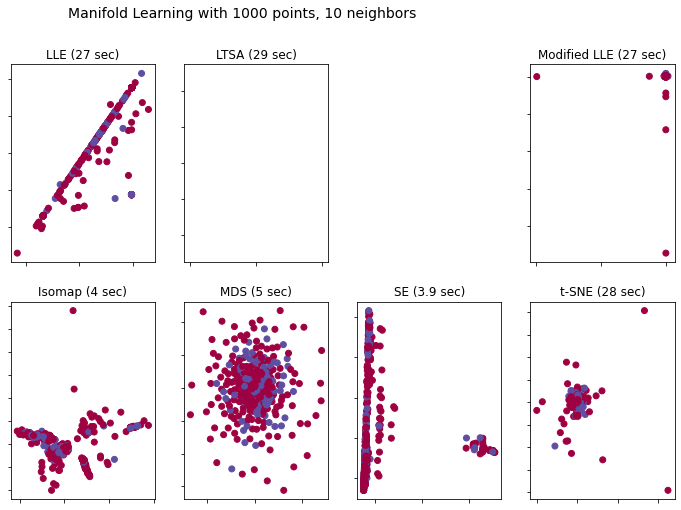

In [19]:

from collections import OrderedDict
from functools import partial
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
# X, color = datasets.make_s_curve(n_points, random_state=0)
X, color = sampleTest[:],integer_encoded[:]

n_neighbors = 10
n_components = 2

# Create figure
fig = plt.figure(figsize=(15, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

# # Add 3d scatter plot
# ax = fig.add_subplot(251,)
# ax.scatter(X[:], c=color, cmap=plt.cm.Spectral)
# ax.view_init(4, -72)

# Set-up manifold methods
LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors, n_components, eigen_solver='auto')

methods = OrderedDict()
methods['LLE'] = LLE(method='standard')
methods['LTSA'] = LLE(method='ltsa')
methods['Hessian LLE'] = LLE(method='hessian')
methods['Modified LLE'] = LLE(method='modified')
methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
                                           n_neighbors=n_neighbors)
methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0)

# Plot results
for i, (label, method) in enumerate(methods.items()):
    try:
        t0 = time()
        Y = method.fit_transform(X)
        t1 = time()
        print("%s: %.2g sec" % (label, t1 - t0))
        ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
        ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
        ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')
    except:
        continue

plt.show()

In [20]:
# for m,n in zip(sampleTest,y):
#     print(np.mean(m),n)
    
    

In [90]:
X_train, X_test, y_train, y_test = train_test_split(
                sampleTest, onehot_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
                X_train, y_train, test_size=0.25,random_state=42)

In [91]:
X_train,X_test,X_val=torch.from_numpy(X_train).float(),torch.from_numpy(X_test).float(),torch.from_numpy(X_val).float()
y_train,y_test,y_val=torch.from_numpy(y_train).float(),torch.from_numpy(y_test).float(),torch.from_numpy(y_val).float()


In [92]:
# # X_train,X_test,X_val,y_train,y_test,y_val = load_raw_data('labelsbyhumanpath','sourcePath')
# X_train,X_test,X_val,y_train,y_test,y_val = mock_raw_data(4,CATEGORY_COUNT)
# X_train,X_test,X_val=torch.from_numpy(X_train).float(),torch.from_numpy(X_test).float(),torch.from_numpy(X_val).float()
# y_train,y_test,y_val=torch.from_numpy(y_train).float(),torch.from_numpy(y_test).float(),torch.from_numpy(y_val).float()

# # labelsbyhumanpath = Path('/scratch/enis/data/nna/labeling/results/')
# # with open(labelsbyhumanpath/"np_array_Ymatrix.npy", 'rb') as f:
# #     y_true = np.load(f)

# Counter(np.argmax(y_train,axis=1).tolist()),Counter(np.argmax(y_val,axis=1).tolist()),Counter(np.argmax(y_test,axis=1).tolist())


In [93]:

# X_train2=np.interp(X_train, (X_train.min(), X_train.max()), (-32768 , 32767))
# torch.from_numpy(X_train2).float()


In [94]:
# y_val

In [95]:
# smaple_index=10
# X_train[smaple_index,:],y_train[smaple_index,]


In [96]:
# X_train[0,:].shape

In [97]:
# multiply(torch.ones((1,2)),torch.ones((1,2)))

In [87]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __init__(self, maxMelLen, sampling_rate):
        # sr = 44100 etc
        self.maxMelLen = maxMelLen
        self.sampling_rate = sampling_rate

    def __call__(self, sample):
        x, y = sample
        #https://github.com/PCerles/audio/blob/3803d0b27a4e13efa760227ef6c71d0f3753aa98/test/test_transforms.py#L262
        #librosa defaults
        n_fft = 2048
        hop_length = 512
        power = 2.0
        n_mels = 128
        n_mfcc = 40
        # htk is false in librosa, no setting in torchaudio -?
        # norm is 1 in librosa, no setting in torchaudio -?
        melspect_transform = torchaudio.transforms.MelSpectrogram(sample_rate=self.sampling_rate, window_fn=torch.hann_window,
                                                                  hop_length=hop_length, n_mels=n_mels, n_fft=n_fft)

    
        db_transform = torchaudio.transforms.AmplitudeToDB("power", 80.)
        mel = melspect_transform(x.reshape(-1))
#         print(mel.shape)
        an_x = db_transform(mel)
#         print(an_x.shape)
        #librosa version
#         mel = librosa.feature.melspectrogram(y=x.reshape(-1),
#                                              sr=self.sampling_rate)
#         an_x = librosa.power_to_db(mel, ref=np.max)
#         an_x = an_x.astype("float32")
#         y = y.astype('float32')
        an_x = an_x[:, :self.maxMelLen]
        # 2-d conv
#         x = an_x.reshape(1, *an_x.shape[:])
        # 1-d conv
#         an_x = an_x.reshape(1, an_x.shape[0]*an_x.shape[1])
        an_x = an_x.reshape(1, an_x.shape[0],an_x.shape[1])

        
        return an_x,y

# #test
# maxMelLen_test = 850
# SAMPLING_RATE_test = 48000
# sample_len_seconds = 10
# # to_tensor works on single sample
# sample_count = 1
# xx_test = torch.ones((sample_count,SAMPLING_RATE_test*sample_len_seconds))
# y_values = torch.ones(sample_count)
# 
# toTensor = ToTensor(maxMelLen_test,SAMPLING_RATE_test)
# x_out,y_out=toTensor((xx_test,y_values))
# x_out.shape,y_out.shape

In [73]:
m

array([-13298, -13302, -13296, ...,  -1830,  -1880,  -1824], dtype=int16)

In [105]:
# create mel spectogram for visuals

maxMelLen_test = 850
SAMPLING_RATE_test = 48000
sample_len_seconds = 10
# to_tensor works on single sample
sample_count = 1
# xx_test = torch.ones((sample_count,SAMPLING_RATE_test*sample_len_seconds))
y_values = torch.ones(sample_count)
toTensor = ToTensor(maxMelLen_test,SAMPLING_RATE_test)
sample_test_mel=[]
for m in sampleTest:
    x_out,y_out=toTensor((torch.from_numpy(m).float(),y_values))
    sample_test_mel.append(x_out)

# x_out.shape,y_out.shape
sample_test_mel_cat=torch.cat(sample_test_mel,axis=0)

In [106]:
sample_test_mel_cat_np = sample_test_mel_cat.numpy()
sample_test_mel_cat_np_flat=sample_test_mel_cat_np.reshape(sample_test_mel_cat.shape[0],-1)

/scratch/enis/conda/envs/soundenv3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_neighbors=10, n_components=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


LLE: 5.3 sec


/scratch/enis/conda/envs/soundenv3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:936: LinAlgWarning: Diagonal number 6 is exactly zero. Singular matrix.
  self.M_lu = lu_factor(M)


LTSA: 5.5 sec
Hessian LLE: 6 sec
Modified LLE: 4.9 sec
Isomap: 2.3 sec
MDS: 3 sec
SE: 2.1 sec
t-SNE: 5.8 sec


<string>:6: UserWarning: Warning: converting a masked element to nan.
/scratch/enis/conda/envs/soundenv3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


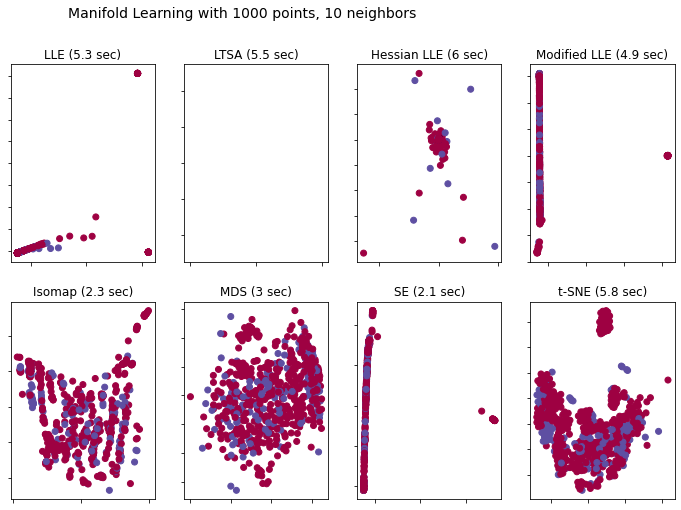

In [101]:

from collections import OrderedDict
from functools import partial
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
# X, color = datasets.make_s_curve(n_points, random_state=0)
X, color = sample_test_mel_cat_np_flat,integer_encoded[:]

n_neighbors = 10
n_components = 2

# Create figure
fig = plt.figure(figsize=(15, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

# # Add 3d scatter plot
# ax = fig.add_subplot(251,)
# ax.scatter(X[:], c=color, cmap=plt.cm.Spectral)
# ax.view_init(4, -72)

# Set-up manifold methods
LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors, n_components, eigen_solver='auto')

methods = OrderedDict()
methods['LLE'] = LLE(method='standard')
methods['LTSA'] = LLE(method='ltsa')
methods['Hessian LLE'] = LLE(method='hessian',eigen_solver='dense')
methods['Modified LLE'] = LLE(method='modified')
methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
                                           n_neighbors=n_neighbors)
methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0)

# Plot results
for i, (label, method) in enumerate(methods.items()):

    t0 = time()
    Y = method.fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (label, t1 - t0))
    ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')


plt.show()

In [107]:
sample_test_mel_cat_np.shape

(589, 128, 850)

In [ ]:
for m,n in zip(sample_test_mel_cat_np[15:27],y[15:27]):
    plt.figure(figsize=(8, 2))
    plt.imshow(m, aspect='auto')
    plt.colorbar()
    plt.tight_layout()
    plt.title(n)


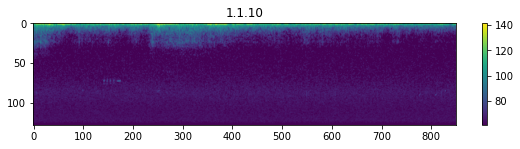

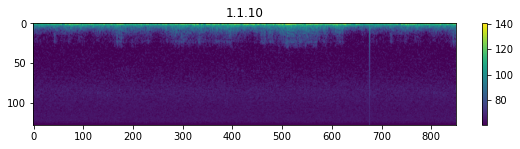

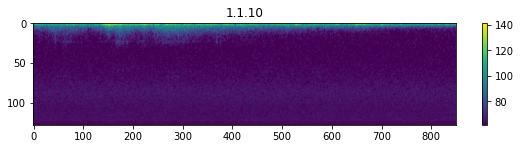

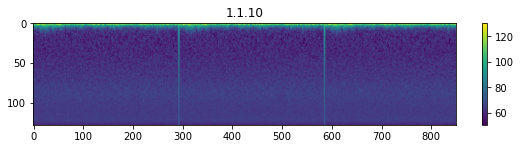

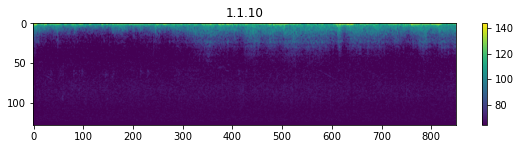

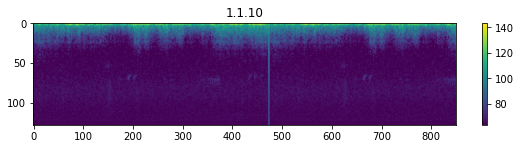

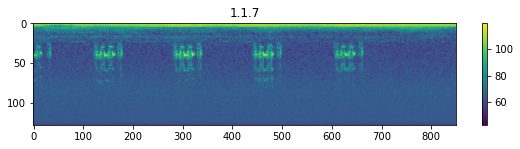

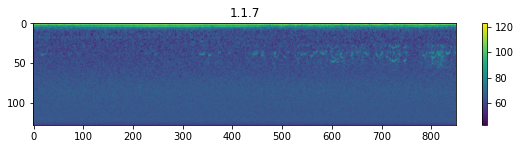

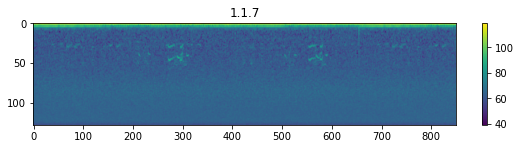

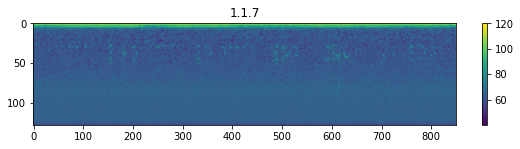

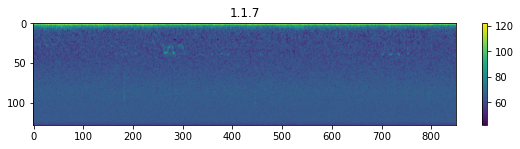

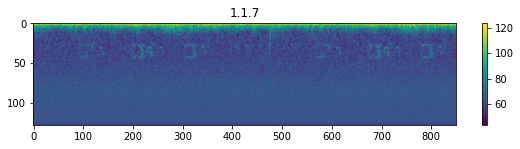

In [128]:
for m,n in zip(sample_test_mel_cat_np[15:27],y[15:27]):
    plt.figure(figsize=(8, 2))
    plt.imshow(m, aspect='auto')
    plt.colorbar()
    plt.tight_layout()
    plt.title(n)


In [99]:
# X_train,X_test,X_val,y_train,y_test,y_val
X_train[:].shape

torch.Size([353, 480000])

In [100]:
# toTensor = ToTensor(maxMelLen_test,SAMPLING_RATE_test)
# x_out2,y_out=toTensor((X_train[1:2,:],y_train))
# x_out.shape,y_out.shape

In [101]:
# torch.mean(x_out[0]),torch.mean(x_out2[0])
# y_train

In [102]:
# X_train,y_train

In [103]:

# pitch = augmentations.pitch_shift_n_stepsClass(
#     runconfigs.SAMPLING_RATE, config['pitch_shift_n_steps'])
# noise = augmentations.addNoiseClass(config['noise_factor'])
# strech = augmentations.time_stretchClass(runconfigs.SAMPLING_RATE*runconfigs.EXCERPT_LENGTH,
#                                             config['time_stretch_factor'],
#                                             isRandom=True)
# shift = augmentations.shiftClass(config['roll_rate'], isRandom=True)
maxMelLen = 850 # old 850
# toTensor = augmentations.ToTensor(maxMelLen,runconfigs.SAMPLING_RATE)
toTensor = ToTensor(maxMelLen,runconfigs.SAMPLING_RATE)

In [104]:
from ignite.metrics import EpochMetric


def roc_auc_perClass_compute_fn(y_preds, y_targets):
    try:
        from sklearn.metrics import roc_auc_score
    except ImportError:
        raise RuntimeError(
            "This contrib module requires sklearn to be installed.")

    y_true = y_targets.numpy()
    y_pred = y_preds.numpy()
#     print(y_pred,y_true)
#     res = []
#     for y_true_perClass_Index in y_true.shape[1]:
#         res.append(
#             roc_auc_score(y_true[:, y_true_perClass_Index],
#                           y_pred[:, y_true_perClass_Index]))
    res = roc_auc_score(y_true, y_pred, average=None)
    return res


#[docs]
class ROC_AUC_perClass(EpochMetric):
    """Computes Area Under the Receiver Operating Characteristic Curve (ROC AUC)
  accumulating predictions and the ground-truth during an epoch and applying
  `sklearn.metrics.roc_auc_score <http://scikit-learn.org/stable/modules/generated/
  sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score>`_ .

  Args:
      output_transform (callable, optional): a callable that is used to transform the
          :class:`~ignite.engine.engine.Engine`'s ``process_function``'s output into the
          form expected by the metric. This can be useful if, for example, you have a multi-output model and
          you want to compute the metric with respect to one of the outputs.
      check_compute_fn (bool): Optional default False. If True, `roc_curve
          <http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#
          sklearn.metrics.roc_auc_score>`_ is run on the first batch of data to ensure there are
          no issues. User will be warned in case there are any issues computing the function.

  ROC_AUC expects y to be comprised of 0's and 1's. y_pred must either be probability estimates or confidence
  values. To apply an activation to y_pred, use output_transform as shown below:

  .. code-block:: python

      def activated_output_transform(output):
          y_pred, y = output
          y_pred = torch.sigmoid(y_pred)
          return y_pred, y

      roc_auc = ROC_AUC(activated_output_transform)

  """
    def __init__(self,
                 output_transform=lambda x: x,
                 check_compute_fn: bool = False):
#         print(output_transform)
        super(ROC_AUC_perClass,
              self).__init__(roc_auc_perClass_compute_fn,
                             output_transform=output_transform,
                             check_compute_fn=check_compute_fn)


In [105]:

def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    """
  Utility function for computing output of convolutions
  takes a tuple of (h,w) and returns a tuple of (h,w)
  """
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor(((h_w[0] + (2 * pad) - (dilation *
                                      (kernel_size[0] - 1)) - 1) / stride) + 1)
    w = floor(((h_w[1] + (2 * pad) - (dilation *
                                      (kernel_size[1] - 1)) - 1) / stride) + 1)
    return h, w

# mel.shape,an_x.shape,X_train.shape
class testModel(nn.Module):
    '''A simple model for testing by overfitting.
    '''
    def __init__(self, out_channels, h_w, kernel_size, FLAT=False,output_shape=(10,)):
        # h_w: height will be always one since we use 1d convolution 
        super(testModel, self).__init__()
        self.out_channels = out_channels
        #### CONV
        self.conv1 = nn.Conv1d(in_channels=1, # depth of image == depth of filters
                               out_channels=self.out_channels, # number of filters 
                               kernel_size=kernel_size, # size of the filters/kernels
                               padding=1)

        self.conv1_shape = conv_output_shape(h_w, kernel_size=kernel_size, stride=1, pad=1, dilation=1)
        # conv is 1d
        self.conv1_shape = (1,self.conv1_shape[1])
        
        self.fc1 = nn.Linear(self.out_channels * self.conv1_shape[0] *self.conv1_shape[1], 100)  # 100

        self.fc2 = nn.Linear(100,output_shape[0])
        
    def forward(self, x):
#         x = x.reshape(1,)
#         print(x.shape) #  50,1,108800 (850*128)
        x = F.relu(self.conv1(x))
#         x = self.pool(x)
        # x = self.drop(x)
#         print(x.shape)# 58, 2, 108801
#         print(self.conv1_shape)
#         print(x.shape)
        x = x.view(-1, self.out_channels * self.conv1_shape[0] *self.conv1_shape[1])
        # batch_norm is missing
        x = F.relu((self.fc1(x)))
        x = (self.fc2(x))

#         x = self.drop(x)

#         x = self.fc4(x)
#         x = torch.sigmoid(x)
#                 x = F.log_softmax(x,dim=1)
        return x

# test
input_shape=(1,(850*128))
output_shape=(10,)
testModel_ins=testModel(out_channels=2,h_w=input_shape,kernel_size=2,output_shape=output_shape)
# a.conv1.weight
a_out=testModel_ins(torch.ones((3,1,input_shape[1])))

a_out_correct=torch.zeros(a_out.shape)
a_out_correct[0][:]=1
a_out_correct
a_out.detach().numpy()

torch.exp(a_out),a_out

(tensor([[1.0732, 0.9518, 0.9517, 0.9840, 1.0387, 1.1001, 1.0751, 0.9601, 0.9937,
          0.9379],
         [1.0732, 0.9518, 0.9517, 0.9840, 1.0387, 1.1001, 1.0751, 0.9601, 0.9937,
          0.9379],
         [1.0732, 0.9518, 0.9517, 0.9840, 1.0387, 1.1001, 1.0751, 0.9601, 0.9937,
          0.9379]], grad_fn=<ExpBackward>),
 tensor([[ 0.0707, -0.0494, -0.0495, -0.0161,  0.0380,  0.0954,  0.0724, -0.0407,
          -0.0063, -0.0641],
         [ 0.0707, -0.0494, -0.0495, -0.0161,  0.0380,  0.0954,  0.0724, -0.0407,
          -0.0063, -0.0641],
         [ 0.0707, -0.0494, -0.0495, -0.0161,  0.0380,  0.0954,  0.0724, -0.0407,
          -0.0063, -0.0641]], grad_fn=<AddmmBackward>))

In [106]:

# for y_true_perClass_Index in a_out_correct.shape[1]:
#     print(y_true_perClass_Index)

In [107]:
# from ignite.contrib.metrics import ROC_AUC
# from nna.exp.metrics import ROC_AUC_perClass
def activated_output_transform(output):
    y_pred, y = output
#     y_pred = torch.exp(y_pred)
    return y_pred, y

In [108]:
asd=ROC_AUC_perClass(activated_output_transform)
asd.update((a_out,a_out_correct))
asd.compute()

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [109]:

transformCompose = transforms.Compose([
#     pitch,
#     strech,
#     shift,
#     noise,
    toTensor,
])


sound_datasets = {
    phase: runutils.audioDataset(XY[0], XY[1], transform=transformCompose)
    for phase, XY in
    zip(['train', 'val', 'test'],
        [[X_train, y_train], [X_val, y_val], [X_test, y_test]])
}

dataloaders = {
    x: torch.utils.data.DataLoader(sound_datasets[x], **params)
    for x in ['train', 'val', 'test']
}

# this will change
h_w = [128, 850]
kernel_size = (3, 3)
# if config['CNNLayer_count'] == 1:
#     model = modelArchs.NetCNN1(config['CNN_filters_1'], h_w,
#                                 kernel_size).float().to(device)

# if config['CNNLayer_count'] == 2:
#     model = modelArchs.NetCNN2(config['CNN_filters_1'], config.CNN_filters_2,
#                                 h_w, kernel_size,
#                                 kernel_size).float().to(device)

#simpler model

output_shape=(CATEGORY_COUNT,)
model = testModel(out_channels=2,h_w=(1,h_w[0]*h_w[1]),kernel_size=kernel_size[0]*kernel_size[0],output_shape=output_shape)
model.float().to(device)

# device is defined before

model.float().to(device)  # Move model before creating optimizer
optimizer = torch.optim.AdamW(model.parameters(),
#                                 weight_decay=config['weight_decay'],
                             )



criterion = nn.BCEWithLogitsLoss()
# statHistory={'valLoss':[],'trainLoss':[],'trainAUC':[],'valAUC':[]}

metrics = {
    'loss': Loss(criterion),  # 'accuracy': Accuracy(),
#     'ROC_AUC': ROC_AUC(runutils.activated_output_transform),
    'ROC_AUC': ROC_AUC_perClass(activated_output_transform),

}


In [110]:
model

testModel(
  (conv1): Conv1d(1, 2, kernel_size=(9,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=217588, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [111]:
trainloader = dataloaders['train']

In [112]:
# for epoch in range(20000):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data

#         # zero the parameter gradients
#         optimizer.zero_grad()
#         inputs=inputs.to(device)
#         # forward + backward + optimize
#         outputs = model(inputs)
#         outputs = outputs.to('cpu')
#         loss = criterion(outputs, labels)
# #         print(outputs)
# #         print(labels)
# #         print(loss)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
# #         print(running_loss)
#         if epoch % 20 == 19:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss))
#             running_loss = 0.0

# print('Finished Training')

In [113]:
model.conv1.weight

Parameter containing:
tensor([[[ 0.2248, -0.1371, -0.3010,  0.1709,  0.1164,  0.2952,  0.2803,
           0.3248, -0.2714]],

        [[-0.0483, -0.0141, -0.1159,  0.1474,  0.2738, -0.0336, -0.1169,
          -0.1066,  0.0378]]], device='cuda:1', requires_grad=True)

In [114]:
model.conv1

Conv1d(1, 2, kernel_size=(9,), stride=(1,), padding=(1,))

In [115]:
model.fc1.weight

Parameter containing:
tensor([[ 1.1732e-03,  3.9693e-04,  6.8751e-04,  ..., -9.9047e-04,
         -3.5253e-04, -7.3829e-04],
        [ 5.1877e-04, -6.2731e-04,  1.5196e-03,  ..., -2.0268e-03,
         -1.5590e-03, -1.3293e-03],
        [-6.5415e-04, -1.9102e-03, -1.9585e-04,  ..., -9.9344e-04,
          1.6376e-03, -1.8756e-03],
        ...,
        [-1.1940e-04, -1.6787e-03,  2.0275e-03,  ...,  1.5088e-03,
          1.6075e-03,  2.2985e-04],
        [-2.9871e-04,  6.5882e-04, -2.0424e-03,  ..., -8.9418e-04,
         -2.8750e-04,  1.5884e-03],
        [-1.1890e-03,  9.6722e-04,  6.7199e-04,  ...,  2.0203e-03,
          2.6562e-05,  1.8072e-03]], device='cuda:1', requires_grad=True)

In [ ]:

print('ready ?')
runutils.run(model, dataloaders, optimizer, criterion, metrics, device,config, runconfigs.PROJECT_NAME)


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


ready ?


wandb: Currently logged in as: enisberk (use `wandb login --relogin` to force relogin)


2021-01-08 06:10:50,614 Trainer INFO: Engine run starting with max_epochs=2000.
/scratch/enis/conda/envs/soundenv3/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370141920/work/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/scratch/enis/conda/envs/soundenv3/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370141920/work/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, retu

train loss 50.56217920881493
val loss 50.419095443466965
validation roc auc [0.46638655 0.53326331] 1


2021-01-08 06:11:15,487 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:11:21,343 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:11:21,346 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:11:21,347 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:11:23,648 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:11:26,151 Val Evaluator INFO: Engine run complete. Time taken: 00:00:05
wandb: WARNING Step must only increase in log calls.  Step 2 < 14; dropping {'lr/group_0': 0.001}.
2021-01-08 06:11:26,182 Trainer INFO: Epoch[2] Complete. Time taken: 00:00:17


train loss 0.6977614426072528
val loss 0.6979068012560828
validation roc auc [0.49404762 0.50595238] 2


2021-01-08 06:11:32,816 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:11:39,120 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:11:39,123 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:11:39,124 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:11:41,397 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:11:43,922 Val Evaluator INFO: Engine run complete. Time taken: 00:00:05
wandb: WARNING Step must only increase in log calls.  Step 3 < 21; dropping {'lr/group_0': 0.001}.
2021-01-08 06:11:43,932 Trainer INFO: Epoch[3] Complete. Time taken: 00:00:18


train loss 0.6971686320331887
val loss 0.6973013797048795
validation roc auc [0.49404762 0.50595238] 3


2021-01-08 06:11:50,921 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:11:57,500 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-08 06:11:57,503 Train Evaluator INFO: Engine run complete. Time taken: 00:00:07
2021-01-08 06:11:57,504 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:11:59,230 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:11:59,564 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 4 < 28; dropping {'lr/group_0': 0.001}.
2021-01-08 06:11:59,574 Trainer INFO: Epoch[4] Complete. Time taken: 00:00:16


train loss 0.6964313835327753
val loss 0.6965437581983663
validation roc auc [0.49404762 0.50595238] 4


2021-01-08 06:12:07,194 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:12:13,510 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:12:13,513 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:12:13,514 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:12:15,417 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:12:15,419 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 5 < 35; dropping {'lr/group_0': 0.001}.
2021-01-08 06:12:15,426 Trainer INFO: Epoch[5] Complete. Time taken: 00:00:16


train loss 0.6956347353735322
val loss 0.6957237508337376
validation roc auc [0.49404762 0.50595238] 5


2021-01-08 06:12:22,418 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:12:28,311 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:12:28,313 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:12:28,314 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:12:30,294 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:12:30,296 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 6 < 42; dropping {'lr/group_0': 0.001}.
2021-01-08 06:12:30,302 Trainer INFO: Epoch[6] Complete. Time taken: 00:00:15


train loss 0.6948234251470808
val loss 0.6948876643584947
validation roc auc [0.49404762 0.50595238] 6


2021-01-08 06:12:36,229 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:12:42,126 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:12:42,128 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:12:42,129 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:12:44,427 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:12:44,429 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 7 < 49; dropping {'lr/group_0': 0.001}.
2021-01-08 06:12:44,435 Trainer INFO: Epoch[7] Complete. Time taken: 00:00:14


train loss 0.6940334901931265
val loss 0.6940730729345548
validation roc auc [0.49404762 0.50595238] 7


2021-01-08 06:12:50,928 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:12:56,917 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:12:56,918 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:12:56,919 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:12:59,065 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:12:59,066 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 8 < 56; dropping {'lr/group_0': 0.001}.
2021-01-08 06:12:59,072 Trainer INFO: Epoch[8] Complete. Time taken: 00:00:15


train loss 0.6931595498374096
val loss 0.6931715860205182
validation roc auc [0.49404762 0.50595238] 8


2021-01-08 06:13:05,292 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:13:11,259 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:13:11,260 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:13:11,261 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:13:13,364 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:13:13,367 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 9 < 63; dropping {'lr/group_0': 0.001}.
2021-01-08 06:13:13,373 Trainer INFO: Epoch[9] Complete. Time taken: 00:00:14


train loss 0.6922051297031111
val loss 0.6921868586944322
validation roc auc [0.49404762 0.50595238] 9


2021-01-08 06:13:19,851 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:13:26,921 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-08 06:13:26,924 Train Evaluator INFO: Engine run complete. Time taken: 00:00:07
2021-01-08 06:13:26,925 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:13:29,042 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:13:29,043 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 10 < 70; dropping {'lr/group_0': 0.001}.
2021-01-08 06:13:29,050 Trainer INFO: Epoch[10] Complete. Time taken: 00:00:16


train loss 0.6914096530368578
val loss 0.6913659168502032
validation roc auc [0.49404762 0.50595238] 10


2021-01-08 06:13:34,979 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:13:41,197 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:13:41,198 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:13:41,199 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:13:43,168 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:13:43,170 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 11 < 77; dropping {'lr/group_0': 0.001}.
2021-01-08 06:13:43,176 Trainer INFO: Epoch[11] Complete. Time taken: 00:00:14


train loss 0.6906183417728197
val loss 0.6905491897615336
validation roc auc [0.49404762 0.50595238] 11


2021-01-08 06:13:49,822 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:13:55,418 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:13:55,419 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:13:55,421 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:13:57,337 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:13:57,340 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 12 < 84; dropping {'lr/group_0': 0.001}.
2021-01-08 06:13:57,346 Trainer INFO: Epoch[12] Complete. Time taken: 00:00:14


train loss 0.6897082713778229
val loss 0.6896097235760447
validation roc auc [0.49404762 0.50595238] 12


2021-01-08 06:14:03,491 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:14:09,102 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:14:09,104 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:14:09,105 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:14:10,926 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:14:10,928 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 13 < 91; dropping {'lr/group_0': 0.001}.
2021-01-08 06:14:10,934 Trainer INFO: Epoch[13] Complete. Time taken: 00:00:14


train loss 0.688789423565689
val loss 0.6886610004861476
validation roc auc [0.49404762 0.50595238] 13


2021-01-08 06:14:17,184 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:14:23,851 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-08 06:14:23,854 Train Evaluator INFO: Engine run complete. Time taken: 00:00:07
2021-01-08 06:14:23,855 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:14:25,475 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:14:25,476 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 14 < 98; dropping {'lr/group_0': 0.001}.
2021-01-08 06:14:25,482 Trainer INFO: Epoch[14] Complete. Time taken: 00:00:15


train loss 0.6878432209363402
val loss 0.6876838308269695
validation roc auc [0.49404762 0.50595238] 14


2021-01-08 06:14:31,407 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:14:36,772 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:05
2021-01-08 06:14:36,775 Train Evaluator INFO: Engine run complete. Time taken: 00:00:05
2021-01-08 06:14:36,776 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:14:39,023 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:14:39,025 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 15 < 105; dropping {'lr/group_0': 0.001}.
2021-01-08 06:14:39,030 Trainer INFO: Epoch[15] Complete. Time taken: 00:00:14


train loss 0.6868277232640188
val loss 0.6866349335444175
validation roc auc [0.49404762 0.50595238] 15


2021-01-08 06:14:45,271 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:14:51,632 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:14:51,633 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:14:51,634 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:14:53,718 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:14:53,720 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 16 < 112; dropping {'lr/group_0': 0.001}.
2021-01-08 06:14:53,726 Trainer INFO: Epoch[16] Complete. Time taken: 00:00:15


train loss 0.6859162378919024
val loss 0.6856932821920363
validation roc auc [0.49404762 0.50595238] 16


2021-01-08 06:14:59,623 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:15:05,482 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:15:05,485 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:15:05,486 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:15:07,598 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:15:07,600 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 17 < 119; dropping {'lr/group_0': 0.001}.
2021-01-08 06:15:07,605 Trainer INFO: Epoch[17] Complete. Time taken: 00:00:14


train loss 0.6850204371527977
val loss 0.6847676260996673
validation roc auc [0.49404762 0.50595238] 17


2021-01-08 06:15:13,999 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:15:20,106 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:15:20,108 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:15:20,110 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:15:22,224 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:15:22,226 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 18 < 126; dropping {'lr/group_0': 0.001}.
2021-01-08 06:15:22,232 Trainer INFO: Epoch[18] Complete. Time taken: 00:00:15


train loss 0.6841144690094859
val loss 0.6838313300730818
validation roc auc [0.49404762 0.50595238] 18


2021-01-08 06:15:28,277 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:15:33,784 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:15:33,787 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:15:33,789 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:15:35,956 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:15:35,957 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 19 < 133; dropping {'lr/group_0': 0.001}.
2021-01-08 06:15:35,963 Trainer INFO: Epoch[19] Complete. Time taken: 00:00:14


train loss 0.6831413858673052
val loss 0.6828255188667168
validation roc auc [0.49404762 0.50595238] 19


2021-01-08 06:15:41,963 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:15:47,877 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:15:47,880 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:15:47,881 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:15:49,853 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:15:49,855 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 20 < 140; dropping {'lr/group_0': 0.001}.
2021-01-08 06:15:49,860 Trainer INFO: Epoch[20] Complete. Time taken: 00:00:14


train loss 0.6821534925749889
val loss 0.6818040174953008
validation roc auc [0.49404762 0.50595238] 20


2021-01-08 06:15:55,931 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:16:01,496 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:16:01,499 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:16:01,500 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:16:03,594 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:16:03,596 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 21 < 147; dropping {'lr/group_0': 0.001}.
2021-01-08 06:16:03,601 Trainer INFO: Epoch[21] Complete. Time taken: 00:00:14


train loss 0.6811816130076184
val loss 0.6807989841800625
validation roc auc [0.49404762 0.50595238] 21


2021-01-08 06:16:09,643 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:16:15,682 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:16:15,685 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:16:15,687 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:16:17,605 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:16:17,606 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 22 < 154; dropping {'lr/group_0': 0.001}.
2021-01-08 06:16:17,612 Trainer INFO: Epoch[22] Complete. Time taken: 00:00:14


train loss 0.6801646194782203
val loss 0.6797469652305215
validation roc auc [0.49404762 0.50595238] 22


2021-01-08 06:16:24,045 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:16:29,749 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:16:29,751 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:16:29,752 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:16:31,570 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:16:31,572 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 23 < 161; dropping {'lr/group_0': 0.001}.
2021-01-08 06:16:31,578 Trainer INFO: Epoch[23] Complete. Time taken: 00:00:14


train loss 0.6791931873678148
val loss 0.6787419359562761
validation roc auc [0.49404762 0.50595238] 23


2021-01-08 06:16:37,329 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:16:42,953 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:16:42,954 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:16:42,955 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:16:44,983 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:16:44,985 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 24 < 168; dropping {'lr/group_0': 0.001}.
2021-01-08 06:16:44,992 Trainer INFO: Epoch[24] Complete. Time taken: 00:00:13


train loss 0.678228425743222
val loss 0.6777436056379544
validation roc auc [0.49404762 0.50595238] 24


2021-01-08 06:16:50,626 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:16:55,756 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:05
2021-01-08 06:16:55,759 Train Evaluator INFO: Engine run complete. Time taken: 00:00:05
2021-01-08 06:16:55,760 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:16:57,622 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:16:57,624 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 25 < 175; dropping {'lr/group_0': 0.001}.
2021-01-08 06:16:57,630 Trainer INFO: Epoch[25] Complete. Time taken: 00:00:13


train loss 0.6771420250533323
val loss 0.6766188932677447
validation roc auc [0.49404762 0.50595238] 25


2021-01-08 06:17:03,244 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:17:08,821 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:17:08,822 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:17:08,823 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:17:10,785 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:17:10,788 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 26 < 182; dropping {'lr/group_0': 0.001}.
2021-01-08 06:17:10,794 Trainer INFO: Epoch[26] Complete. Time taken: 00:00:13


train loss 0.6761406092738295
val loss 0.6755821331072662
validation roc auc [0.49404762 0.50595238] 26


2021-01-08 06:17:16,606 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:17:22,026 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:05
2021-01-08 06:17:22,029 Train Evaluator INFO: Engine run complete. Time taken: 00:00:05
2021-01-08 06:17:22,030 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:17:23,795 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:17:23,796 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 27 < 189; dropping {'lr/group_0': 0.001}.
2021-01-08 06:17:23,803 Trainer INFO: Epoch[27] Complete. Time taken: 00:00:13


train loss 0.6750998419337503
val loss 0.674504237659907
validation roc auc [0.49404762 0.50595238] 27


2021-01-08 06:17:29,619 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:17:35,050 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:05
2021-01-08 06:17:35,052 Train Evaluator INFO: Engine run complete. Time taken: 00:00:05
2021-01-08 06:17:35,052 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:17:36,908 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:17:36,909 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 28 < 196; dropping {'lr/group_0': 0.001}.
2021-01-08 06:17:36,915 Trainer INFO: Epoch[28] Complete. Time taken: 00:00:13


train loss 0.6740247293167007
val loss 0.6733904521344072
validation roc auc [0.49404762 0.50595238] 28


2021-01-08 06:17:42,795 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:17:48,187 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:05
2021-01-08 06:17:48,190 Train Evaluator INFO: Engine run complete. Time taken: 00:00:05
2021-01-08 06:17:48,191 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:17:50,017 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:17:50,019 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 29 < 203; dropping {'lr/group_0': 0.001}.
2021-01-08 06:17:50,025 Trainer INFO: Epoch[29] Complete. Time taken: 00:00:13


train loss 0.6730064727766993
val loss 0.6723352236262823
validation roc auc [0.49404762 0.50595238] 29


2021-01-08 06:17:56,028 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:18:01,339 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:05
2021-01-08 06:18:01,342 Train Evaluator INFO: Engine run complete. Time taken: 00:00:05
2021-01-08 06:18:01,343 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:18:03,248 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:18:03,249 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 30 < 210; dropping {'lr/group_0': 0.001}.
2021-01-08 06:18:03,255 Trainer INFO: Epoch[30] Complete. Time taken: 00:00:13


train loss 0.6720702659982459
val loss 0.6713649266857212
validation roc auc [0.49404762 0.50595238] 30


2021-01-08 06:18:08,666 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:18:14,070 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:05
2021-01-08 06:18:14,072 Train Evaluator INFO: Engine run complete. Time taken: 00:00:05
2021-01-08 06:18:14,073 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:18:16,031 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:18:16,033 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 31 < 217; dropping {'lr/group_0': 0.001}.
2021-01-08 06:18:16,039 Trainer INFO: Epoch[31] Complete. Time taken: 00:00:13


train loss 0.6710819780995421
val loss 0.6703402248479552
validation roc auc [0.49404762 0.50595238] 31


2021-01-08 06:18:21,468 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:18:26,963 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:05
2021-01-08 06:18:26,966 Train Evaluator INFO: Engine run complete. Time taken: 00:00:05
2021-01-08 06:18:26,967 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:18:28,714 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:18:28,715 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 32 < 224; dropping {'lr/group_0': 0.001}.
2021-01-08 06:18:28,722 Trainer INFO: Epoch[32] Complete. Time taken: 00:00:13


train loss 0.6701179508109268
val loss 0.6693404690694
validation roc auc [0.49404762 0.50595238] 32


2021-01-08 06:18:34,401 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:18:39,565 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:05
2021-01-08 06:18:39,567 Train Evaluator INFO: Engine run complete. Time taken: 00:00:05
2021-01-08 06:18:39,568 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:18:41,229 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:18:41,232 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 33 < 231; dropping {'lr/group_0': 0.001}.
2021-01-08 06:18:41,239 Trainer INFO: Epoch[33] Complete. Time taken: 00:00:13


train loss 0.6691821938533621
val loss 0.6683697326708649
validation roc auc [0.49404762 0.50595238] 33


2021-01-08 06:18:46,929 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:18:52,469 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:18:52,472 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:18:52,473 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:18:54,282 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:18:54,284 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 34 < 238; dropping {'lr/group_0': 0.001}.
2021-01-08 06:18:54,291 Trainer INFO: Epoch[34] Complete. Time taken: 00:00:13


train loss 0.6682052137831452
val loss 0.6673559425240856
validation roc auc [0.49404762 0.50595238] 34


2021-01-08 06:18:59,949 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:19:05,656 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:19:05,659 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:19:05,660 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:19:07,620 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:19:07,621 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 35 < 245; dropping {'lr/group_0': 0.001}.
2021-01-08 06:19:07,627 Trainer INFO: Epoch[35] Complete. Time taken: 00:00:13


train loss 0.6671761061584646
val loss 0.6662877303058818
validation roc auc [0.49404762 0.50595238] 35


2021-01-08 06:19:13,221 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:19:18,844 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:19:18,847 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:19:18,849 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:19:20,582 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:19:20,584 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 36 < 252; dropping {'lr/group_0': 0.001}.
2021-01-08 06:19:20,589 Trainer INFO: Epoch[36] Complete. Time taken: 00:00:13


train loss 0.6661963697533432
val loss 0.665270485110202
validation roc auc [0.49404762 0.50595238] 36


2021-01-08 06:19:26,257 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:19:31,883 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:19:31,886 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:19:31,887 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:19:33,673 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:19:33,675 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 37 < 259; dropping {'lr/group_0': 0.001}.
2021-01-08 06:19:33,681 Trainer INFO: Epoch[37] Complete. Time taken: 00:00:13


train loss 0.6652409653825733
val loss 0.6642781496047974
validation roc auc [0.49404762 0.50595238] 37


2021-01-08 06:19:39,240 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:19:44,715 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:05
2021-01-08 06:19:44,717 Train Evaluator INFO: Engine run complete. Time taken: 00:00:05
2021-01-08 06:19:44,718 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:19:46,568 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:19:46,570 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 38 < 266; dropping {'lr/group_0': 0.001}.
2021-01-08 06:19:46,576 Trainer INFO: Epoch[38] Complete. Time taken: 00:00:13


train loss 0.6643551046044563
val loss 0.6633577912540759
validation roc auc [0.49404762 0.50595238] 38


2021-01-08 06:19:52,113 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:19:58,118 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:19:58,121 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:19:58,122 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:20:00,334 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:20:00,336 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 39 < 273; dropping {'lr/group_0': 0.001}.
2021-01-08 06:20:00,342 Trainer INFO: Epoch[39] Complete. Time taken: 00:00:14


train loss 0.6636348468048376
val loss 0.6626093326988867
validation roc auc [0.49404762 0.50595238] 39


2021-01-08 06:20:06,742 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:20:13,737 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-08 06:20:13,740 Train Evaluator INFO: Engine run complete. Time taken: 00:00:07
2021-01-08 06:20:13,741 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:20:15,670 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:20:15,671 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 40 < 280; dropping {'lr/group_0': 0.001}.
2021-01-08 06:20:15,678 Trainer INFO: Epoch[40] Complete. Time taken: 00:00:15


train loss 0.6627820731897868
val loss 0.6617229227292336
validation roc auc [0.49404762 0.50595238] 40


2021-01-08 06:20:21,974 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:20:28,906 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-08 06:20:28,909 Train Evaluator INFO: Engine run complete. Time taken: 00:00:07
2021-01-08 06:20:28,910 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:20:30,955 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:20:30,956 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 41 < 287; dropping {'lr/group_0': 0.001}.
2021-01-08 06:20:30,962 Trainer INFO: Epoch[41] Complete. Time taken: 00:00:15


train loss 0.6618947874723008
val loss 0.660800244848607
validation roc auc [0.49404762 0.50595238] 41


2021-01-08 06:20:37,308 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:20:43,997 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-08 06:20:44,000 Train Evaluator INFO: Engine run complete. Time taken: 00:00:07
2021-01-08 06:20:44,001 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:20:46,171 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:20:46,172 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 42 < 294; dropping {'lr/group_0': 0.001}.
2021-01-08 06:20:46,180 Trainer INFO: Epoch[42] Complete. Time taken: 00:00:15


train loss 0.6609680605339936
val loss 0.6598363185332994
validation roc auc [0.49404762 0.50595238] 42


2021-01-08 06:20:52,895 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:20:59,843 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-08 06:20:59,846 Train Evaluator INFO: Engine run complete. Time taken: 00:00:07
2021-01-08 06:20:59,847 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:21:01,964 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:21:01,965 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 43 < 301; dropping {'lr/group_0': 0.001}.
2021-01-08 06:21:01,971 Trainer INFO: Epoch[43] Complete. Time taken: 00:00:16


train loss 0.6601520425537153
val loss 0.6589873261370901
validation roc auc [0.49404762 0.50595238] 43


2021-01-08 06:21:09,478 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:21:16,264 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-08 06:21:16,275 Train Evaluator INFO: Engine run complete. Time taken: 00:00:07
2021-01-08 06:21:16,277 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:21:18,427 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:21:18,429 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 44 < 308; dropping {'lr/group_0': 0.001}.
2021-01-08 06:21:18,436 Trainer INFO: Epoch[44] Complete. Time taken: 00:00:16


train loss 0.6593105581934662
val loss 0.6581114399231086
validation roc auc [0.49404762 0.50595238] 44


2021-01-08 06:21:26,305 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:21:33,957 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:08
2021-01-08 06:21:33,958 Train Evaluator INFO: Engine run complete. Time taken: 00:00:08
2021-01-08 06:21:33,959 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:21:36,273 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:21:36,276 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 45 < 315; dropping {'lr/group_0': 0.001}.
2021-01-08 06:21:36,281 Trainer INFO: Epoch[45] Complete. Time taken: 00:00:18


train loss 0.6584595828488595
val loss 0.6572254835549047
validation roc auc [0.49404762 0.50595238] 45


2021-01-08 06:21:45,296 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:21:52,122 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-08 06:21:52,125 Train Evaluator INFO: Engine run complete. Time taken: 00:00:07
2021-01-08 06:21:52,126 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:21:54,217 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:21:54,219 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 46 < 322; dropping {'lr/group_0': 0.001}.
2021-01-08 06:21:54,227 Trainer INFO: Epoch[46] Complete. Time taken: 00:00:18


train loss 0.6576468252257652
val loss 0.6563790339534565
validation roc auc [0.49404762 0.50595238] 46


2021-01-08 06:22:01,539 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:22:08,822 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-08 06:22:08,824 Train Evaluator INFO: Engine run complete. Time taken: 00:00:07
2021-01-08 06:22:08,825 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:22:11,309 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:22:11,312 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 47 < 329; dropping {'lr/group_0': 0.001}.
2021-01-08 06:22:11,317 Trainer INFO: Epoch[47] Complete. Time taken: 00:00:17


train loss 0.656884148505862
val loss 0.6555844828233881
validation roc auc [0.49404762 0.50595238] 47


2021-01-08 06:22:18,436 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:22:25,228 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-08 06:22:25,231 Train Evaluator INFO: Engine run complete. Time taken: 00:00:07
2021-01-08 06:22:25,232 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:22:27,667 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:22:27,669 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 48 < 336; dropping {'lr/group_0': 0.001}.
2021-01-08 06:22:27,675 Trainer INFO: Epoch[48] Complete. Time taken: 00:00:16


train loss 0.6561182298336083
val loss 0.6547862533795632
validation roc auc [0.49404762 0.50595238] 48


2021-01-08 06:22:36,303 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:22:42,977 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-08 06:22:42,979 Train Evaluator INFO: Engine run complete. Time taken: 00:00:07
2021-01-08 06:22:42,980 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:22:45,245 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:22:45,246 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 49 < 343; dropping {'lr/group_0': 0.001}.
2021-01-08 06:22:45,252 Trainer INFO: Epoch[49] Complete. Time taken: 00:00:18


train loss 0.6553721468441884
val loss 0.6540085087388249
validation roc auc [0.49404762 0.50595238] 49


2021-01-08 06:22:52,777 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:22:58,665 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-08 06:22:58,666 Train Evaluator INFO: Engine run complete. Time taken: 00:00:06
2021-01-08 06:22:58,667 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:23:01,715 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:03
2021-01-08 06:23:01,718 Val Evaluator INFO: Engine run complete. Time taken: 00:00:03
wandb: WARNING Step must only increase in log calls.  Step 50 < 350; dropping {'lr/group_0': 0.001}.
2021-01-08 06:23:01,724 Trainer INFO: Epoch[50] Complete. Time taken: 00:00:16


train loss 0.654603364278507
val loss 0.6532067818156744
validation roc auc [0.49404762 0.50595238] 50


2021-01-08 06:23:09,490 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:23:16,162 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-08 06:23:16,165 Train Evaluator INFO: Engine run complete. Time taken: 00:00:07
2021-01-08 06:23:16,166 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-08 06:23:18,131 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-08 06:23:18,132 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
wandb: WARNING Step must only increase in log calls.  Step 51 < 357; dropping {'lr/group_0': 0.001}.
2021-01-08 06:23:18,138 Trainer INFO: Epoch[51] Complete. Time taken: 00:00:16


train loss 0.6540034970548267
val loss 0.6525811421669135
validation roc auc [0.49404762 0.50595238] 51


In [ ]:
model.fc1.weight

In [ ]:

example_input = (torch.ones((1,1,h_w[0]*h_w[1]))*-32767)
example_input = example_input.float().to(device)
out=model(example_input)
out

activated_output_transform((out,out))

In [ ]:
torch.Tensor([10,10,10])

In [ ]:
sum(model.fc1.weight)

In [ ]:
m = nn.Sigmoid()

loss = nn.BCEWithLogitsLoss()
input = torch.tensor([100.0,100,100], requires_grad=True)
# target = torch.empty(3).random_(2)
target = torch.ones(3)
output = loss((input), target)
input,target,output

In [ ]:
input

In [ ]:
target

In [ ]:
output

In [ ]:
m(input)